In [1]:
library('ggplot2')
library('reshape2')
library('ggpubr')
library(glmnet)
library(doMC)
library(survival)
library(data.table)
library(mltools)
library(CoxBoost)
library(randomForestSRC)
library(CoxHD)
library(Hmisc)
library(gridExtra)
library("survminer")
library(dplyr)
library(stringr)

source("../../../../src/tools.R")
options(repr.plot.res        = 100, # set a medium-definition resolution for the jupyter notebooks plots (DPI)
        repr.matrix.max.rows = 250, # set the maximum number of rows displayed
        repr.matrix.max.cols = 250) # set the maximum number of columns displayed

Loading required package: magrittr
Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16

Loading required package: iterators
Loading required package: parallel

Attaching package: ‘data.table’

The following objects are masked from ‘package:reshape2’:

    dcast, melt

Loading required package: prodlim

 randomForestSRC 2.9.0 
 
 Type rfsrc.news() to see new features, changes, and bug fixes. 
 

Loading required package: RColorBrewer
Loading required package: lattice
Loading required package: Formula

Attaching package: ‘Hmisc’

The following object is masked from ‘package:randomForestSRC’:

    impute

The following objects are masked from ‘package:base’:

    format.pval, units


Attaching package: ‘dplyr’

The following object is masked from ‘package:gridExtra’:

    combine

The following objects are masked from ‘package:Hmisc’:

    src, summarize

The following objects are masked from ‘package:data.table’:

    between, first, last

The followin

In [3]:
df_reshuffling <- NULL
for (l in list.files('Reshuffle')){
    if (grepl("_reshuffle_importance.tsv",l)){
        df_tmp <- read.table(paste('Reshuffle/',l,sep=""))
        df_tmp$Ratio <- df_tmp$ref_CI/df_tmp$permuted_CI
        df_tmp <- df_tmp[,c("feature","Ratio","algo","model")]
        df_reshuffling <- rbind(df_reshuffling,df_tmp)     
    }
}

df_bootstrap <- NULL
for (l in list.files('Bootstrap_coef/')){
    if (grepl("_bootstrap",l)){
        if(grepl("_bootstrap_SVM",l)){
            print('a')
            df_tmp <- read.table(paste('../Bootstrap_coef/',l,sep=""),sep=',',header=T)
            df_tmp <- df_tmp[,-1]
            df_tmp <- df_tmp[,c(2,1,3)]
        } else {
            df_tmp <- read.table(paste('Bootstrap_coef/',l,sep=""))
        }
        colnames(df_tmp) <- c("feature","sum_coef","num_selected")
        df_tmp$model_algo <- str_sub(l, 1, str_length(l)-4)
        df_bootstrap <- rbind(df_bootstrap,df_tmp)   
    }
}
df_bootstrap <- df_bootstrap[df_bootstrap$feature!="age.1" & !is.na(df_bootstrap$feature),]
df_bootstrap$model <- sub("_bootstrap_.*$", "", df_bootstrap$model_algo )

dim(df_reshuffling)
dim(df_bootstrap)

[1] 220200      4

[1] 2189    5

In [62]:
df_final <- read.table("full_data_validation.tsv")
eln <- colnames(df_final[,c(113,114,115)])
comp <-  colnames(df_final[,c(89:112)])
age <-  colnames(df_final[,c(84)])

all_gen <- c(1:57)
vect <- apply(X=df_final[,all_gen],2,FUN=function(x) 100*length(which(x==1))/dim(df_final)[1])
gen <-  colnames(df_final[,match(names(vect[vect>=2]),names(df_final))])
              
all_cyto <- c(58:80)
vect <- apply(X=df_final[,all_cyto],2,FUN=function(x) 100*length(which(x==1))/dim(df_final)[1])
cyto <-  colnames(df_final[,match(names(vect[vect>=2]),names(df_final))])
              
clin <-  colnames(df_final[,c(85:87)])
demo <-  colnames(df_final[,c(83,84)])

              
pal <- c(eln="#EE9937",comp="#59A08B",gen="#BFBFBF",cyto="#2b8cbe",clin="#870C14",demo="#a6bddb") 
class(pal)

[1] "character"

In [50]:
# Function showing Feature Importance for the Models



importance <- function (models=unique(df_reshuffling$model),fun=median,width=25,height=40){
    for (model in models){
        set_notebook_plot_size(width,height)
        #Resuflling Importance

        feature_model <- df_reshuffling[df_reshuffling$model==model ,] 
        #%>% filter(str_detect(model, c("0.7|0|1|boost|rfs")))

        feature_model <- feature_model[,c('feature','Ratio','algo')] %>% group_by(feature,algo)  
        #%>% summarize_all(sum)
        feature_model$category <- ifelse(is.element(feature_model$feature,eln),"eln",
                                       ifelse(is.element(feature_model$feature,comp),"comp",
                                             ifelse(is.element(feature_model$feature,gen),"gen",
                                                   ifelse(is.element(feature_model$feature,cyto),"cyto",
                                                         ifelse(is.element(feature_model$feature,clin),"clin","demo")))))

        feature_model$algo <- toupper(feature_model$algo)
        #feature_model$algo <- ifelse(feature_model$algo=="COX","SIMPLE_COX",feature_model$algo)

        # Bootstrapping + Coef Importance
        p <- ggplot(na.omit(feature_model),aes(x=reorder(feature,Ratio,FUN=fun),y=Ratio,fill=category))+geom_boxplot()+facet_wrap(~algo,ncol=6)+
        theme(plot.title = element_text( size=30, face="bold.italic",hjust=0.5),legend.text=element_text(size=10),legend.position="top",
          axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8,size=12),axis.text.y=element_text(size=12),
          axis.title.y = element_text(size = 20),axis.title.x = element_text(size = 20),strip.text = element_text(size=25))+xlab("Selected Features") +
        ylab("Ratio (ref_CI/Permuted_CI) ") + ggtitle(paste(model, "Model Feature importance Reshuffling NEJM Validation"))+coord_flip() +scale_fill_manual(values=pal,limits=names(pal))


        feature_model <- df_bootstrap[startsWith(df_bootstrap$model_algo,paste(model,"_bootstrap_",sep="")) ,] %>% filter(str_detect(model_algo, c("0.7|0|1|boost|rfs|rfx")))

        feature_model <- feature_model[,c('feature','sum_coef','num_selected','model_algo')] %>% group_by(feature,model_algo)  
        #%>% summarize_all(sum)

        feature_model$category <- ifelse(is.element(feature_model$feature,eln),"eln",
                                       ifelse(is.element(feature_model$feature,comp),"comp",
                                             ifelse(is.element(feature_model$feature,gen),"gen",
                                                   ifelse(is.element(feature_model$feature,cyto),"cyto",
                                                         ifelse(is.element(feature_model$feature,clin),"clin","demo")))))

        feature_model$model_algo <- toupper(gsub(".*_bootstrap_", "",feature_model$model_algo ))
        feature_model$model_algo <- ifelse(feature_model$model_algo=="GLM_0","RIDGE",
                                          ifelse(feature_model$model_algo=="GLM_0.7","ELASTIC_NET",
                                                ifelse(feature_model$model_algo=="GLM_1","LASSO",feature_model$model_algo)))

        q <- ggplot(na.omit(feature_model %>% filter(str_detect(model_algo, c("LASSO|RIDGE|ELASTIC_NET|BOOST|RFS|RFX")))),aes(x=reorder(feature,num_selected,FUN=mean),y=num_selected,fill=category))+geom_bar(stat = "identity")+facet_wrap(~model_algo,ncol=6)+
        theme(plot.title = element_text( size=30, face="bold.italic",hjust=0.5),legend.text=element_text(size=10),legend.position="top",
          axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8,size=12),axis.text.y=element_text(size=12),
          axis.title.y = element_text(size = 20),axis.title.x = element_text(size = 20),strip.text = element_text(size=25))+xlab("Selected Features") +
        ylab("Proportion of selection count overall models and algorithms ") + ggtitle(paste(model, "Model Feature importance Bootstrap for Algorithms NEJM Validation"))+coord_flip() +scale_fill_manual(values=pal,limits=names(pal))

        r <-  ggplot(na.omit(feature_model %>% filter(str_detect(model_algo, c("LASSO|RIDGE|ELASTIC_NET")))),aes(x=reorder(feature,sum_coef),y=sum_coef,fill=category))+geom_bar(stat = "identity")+facet_wrap(~model_algo,ncol=5)+
        theme(plot.title = element_text( size=30, face="bold.italic",hjust=0.5),legend.text=element_text(size=10),legend.position="top",
          axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8,size=12),axis.text.y=element_text(size=12),
          axis.title.y = element_text(size = 20),axis.title.x = element_text(size = 20),strip.text = element_text(size=25))+xlab("Selected Features") +
        ylab("Sum of coefficients over GLM Models ") + ggtitle(paste(model, "Coefficients for Cox Penalized Models NEJM Validation"))+coord_flip() +scale_fill_manual(values=pal,limits=names(pal))

#         grid.arrange(p,q,r,nrow=3)
          grid.arrange(p,r,nrow=2)


    }
}

# Selected Models

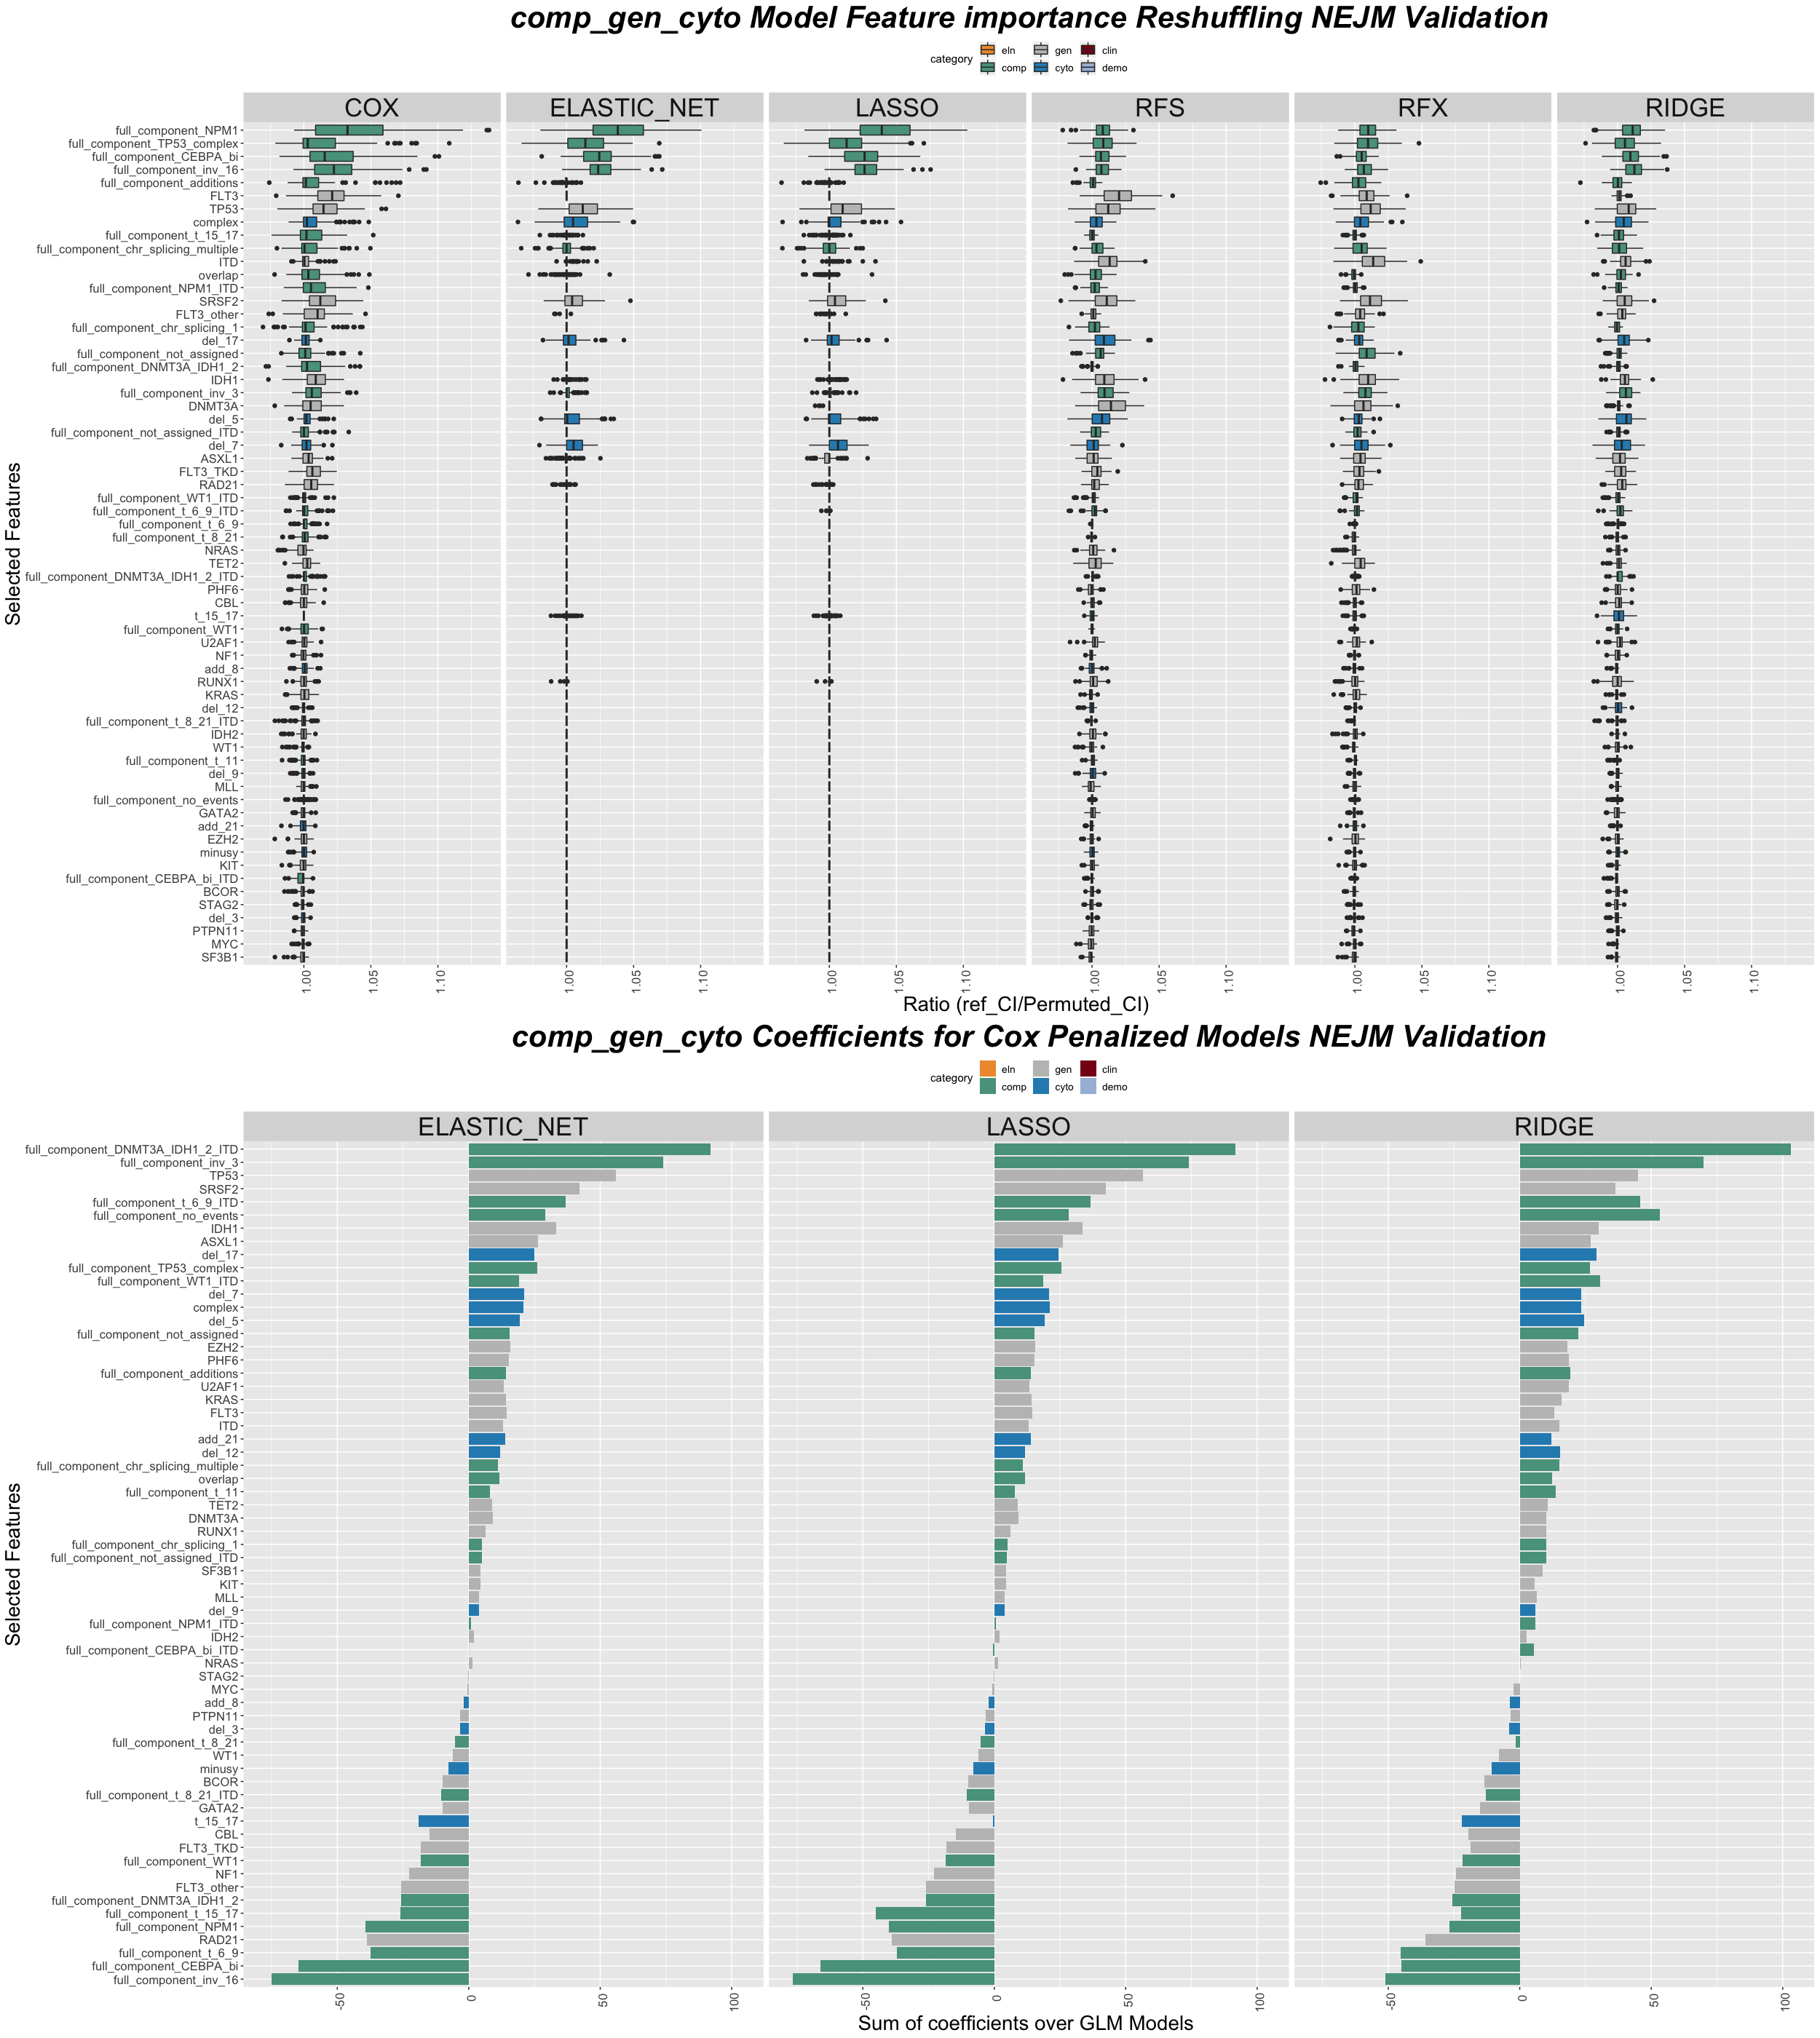

In [57]:
importance(c("comp_gen_cyto"),width=25,height=28,fun=max)